In [2]:
%load_ext autoreload
%autoreload 2
# Copyright (c) Meta Platforms, Inc. and affiliates.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.
import argparse
import dataclasses
import sys
import timeit
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
done


In [3]:
from scannet_dataset import ScanNetDataset
from home_robot.datasets.scannet.referit3d_data import ReferIt3dDataConfig
from home_robot.datasets.scannet.scanrefer_data import ScanReferDataConfig
data = ScanNetDataset(
    root_dir = '/private/home/ssax/home-robot/src/home_robot/home_robot/datasets/scannet/data',
    frame_skip = 180,
    referit3d_config = ReferIt3dDataConfig(),
    scanrefer_config = ScanReferDataConfig(),
)

# Load specific scene
# idx = data.scene_list.index("scene0192_00") #'scene0000_00'
idx = 0
print(f"Loaded images of (h: {data.height}, w: {data.width}) - resized from ({data.DEFAULT_HEIGHT},{data.DEFAULT_WIDTH})")
scene_obs = data.__getitem__(idx, show_progress=True)

import torch
print(torch.cuda.is_available())

# Load GT mesh
from pytorch3d.io import IO, load_obj, load_ply
scene_id = scene_obs['scan_name']
print("Loading GT mesh for", scene_id)
verts = load_ply(data.root_dir / f'scans/{scene_id}/{scene_id}_vh_clean.ply')
aligned_verts = torch.cat([verts[0], torch.ones_like(verts[0][:,:1])], dim=-1) @ scene_obs['axis_align_mats'][0].T


Dropping utterances without explicit mention to the target class 41503->37842
95-th percentile of token length for remaining (training) data is: 24.0
Dropping utterances with more than 24 tokens, 37842->36201
Adding Sr3D as augmentation.
Dataset-size before augmentation: 36201
Dataset-size after augmentation: 102047
(mean) Random guessing among target-class test objects 0.3814
Loaded images of (h: 480, w: 640) - resized from (968.0,1296.0)


Loading scene scene0000_00: 100%|██████████████████████████████████████████████| 31/31 [00:00<00:00, 40.66it/s]


True
Loading GT mesh for scene0000_00


In [ ]:
# K = scene_obs['intrinsics'][0][:3,:3]
# depth = scene_obs['depths'][0].squeeze().unsqueeze(0).unsqueeze(1)
# valid_depth  = (0.1 < depth) & (depth < 4.0)

# xyz = unproject_masked_depth_to_xyz_coordinates(
#     depth = depth,
#     mask  = ~valid_depth,
#     pose  = torch.eye(4).unsqueeze(0),
#     inv_intrinsics = torch.linalg.inv(K).unsqueeze(0),
# )
# rgb = scene_obs['images'][0].reshape(-1,3)[valid_depth.flatten()]
# print(scene_obs['image_paths'][0])
# print(f"Proportion depth valid: {float(valid_depth.float().mean())}")
# print(f"Depth min + max: {float(depth.flatten()[valid_depth.flatten()].min())}, {float(depth.flatten()[valid_depth.flatten()].max())}")
# print("These are the mins-maxes along each world axis. They should be in meters:")
# for i in range(3):
#     print(f"  {i}: ({float(xyz[:,i].min())}, {float(xyz[:,i].max())})")

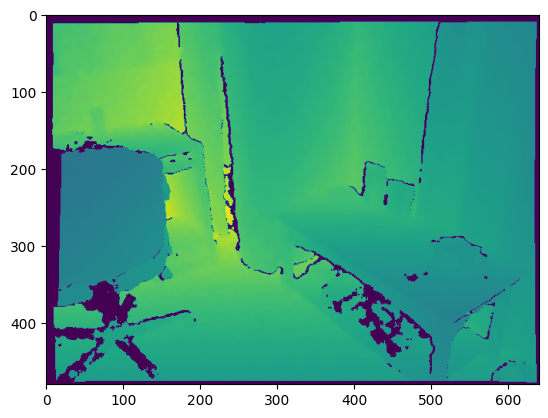

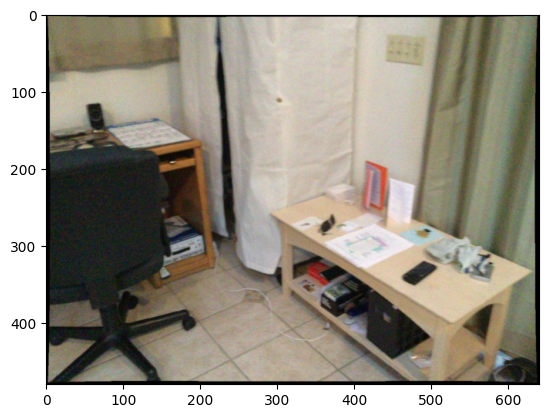

In [4]:
plt.imshow(scene_obs['depths'][0])
plt.show()
plt.imshow(scene_obs['images'][0])
plt.show()


In [5]:
from home_robot.perception.detection.detic.detic_perception import DeticPerception
segmenter = DeticPerception(
        config_file=None,
        vocabulary="coco",
        custom_vocabulary="",
        checkpoint_file=None,
        sem_gpu_id=0,
        # verbose: bool = False,
    )

ModuleNotFoundError: No module named 'detectron2'

In [6]:
plt.imshow(res['semantic_frame'])
plt.show()
plt.imshow(scene_obs['instance_map'][-1] == 0)
plt.show()

NameError: name 'res' is not defined

In [ ]:
# -> SparseVoxelMapWithInstanceViews.show(backend='pytorch3d')

# Plot GT scene
from home_robot.utils.bboxes_3d import BBoxes3D, join_boxes_as_scene, join_boxes_as_batch
from home_robot.utils.bboxes_3d_plotly import plot_scene_with_bboxes
from pytorch3d.vis.plotly_vis import AxisArgs
from pytorch3d.structures import Pointclouds
import seaborn as sns

colors = torch.tensor(sns.color_palette("husl", len(scene_obs['boxes_aligned'])))
gt_boxes = BBoxes3D(
    bounds = [scene_obs['boxes_aligned']],
    # features = [colors[0].unsqueeze(0).expand(27,3)],
    features = [colors],
    names = [scene_obs['box_classes'].unsqueeze(-1)]
)

fig = plot_scene_with_bboxes(
    plots = { f"{scene_id}": { 
                                "Points": svm.global_voxel_grid._pcl,
                                # "Boxes": join_boxes_as_scene(svm.instance_bboxes3d),
                                "All boxes": global_boxes,
                                "Global boxes": global_boxes,
                                "GT boxes": gt_boxes,
                                "GT points": Pointclouds(points=[aligned_verts[:, :3]]),
                                # "cameras": cameras,
                            }
    },
    xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
    yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
    zaxis={"backgroundcolor":"rgb(200, 230, 200)"}, 
    axis_args=AxisArgs(showgrid=True),
    pointcloud_marker_size=3,
    pointcloud_max_points=30_000,
    boxes_wireframe_width=3,
    boxes_add_cross_face_bars=False,
    boxes_name_int_to_display_name_dict = dict(zip([int(i) for i in data.METAINFO['seg_valid_class_ids']], data.METAINFO['classes'])),
    boxes_plot_together=False,
    height=1000,
    # width=1000,
)
fig